In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import time
from datetime import timedelta
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Ερώτημα 1

In [3]:
#Step 1: Loading data (mfccs)
def load_data(path, data = 'train'):
    #set path
    path1 = path+data+"/mfccs/"
     #load data
    X = np.load(path1 + 'X.npy')
    y = np.load(path1 + 'labels.npy')
    #return data
    return X, y
# set path to google drive
path='/content/drive/MyDrive/music_genre_data_di/'
# Load the data
X_train, y_train = load_data(path,'train' )
X_val, y_val = load_data(path,'val' )
X_test, y_test = load_data(path,'test' )
#transform labels to numerical encoding (integer mapping)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

#set device to cpu or gpu based on configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#load data to pytorch dataloaders with batch size 16
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32, device=device),
                              torch.tensor(y_train, dtype=torch.long, device=device))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32, device=device),
                            torch.tensor(y_val, dtype=torch.long, device=device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32, device=device),
                             torch.tensor(y_test, dtype=torch.long, device=device))

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda


In [4]:
#Step 2: Define a Neural Network
#Fully connected neural netwrok class
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        #input size 26 and layer1 128
        self.inputLayer = nn.Linear(26, 128)
        #layer2  size is 32
        self.hiddenLayer = nn.Linear(128, 32)
        #layer3 i-e output has size 4

        self.outputLayer = nn.Linear(32, 4)


    def forward(self, data):
        #forward pass where all layers are applied on input
        out = self.inputLayer(data)
        out = self.hiddenLayer(out)
        out = self.outputLayer(out)
        #return the output of network
        return out


In [5]:
#Step 3: Define the training process
def train(n_epochs, optimizer, data_loader, cost_func, n_network):

    n_network.train()  # Set the model to training mode

    for epoch in range(1,n_epochs+1): #run loop over no. of epochs
        total_loss = 0.0
        # iterate over tarining data
        for x, y in data_loader:
            # set gardient to zero
            optimizer.zero_grad()
            #run forward pass
            pred = n_network(x)
            #compute loss
            loss = cost_func(pred, y)
            #run backward to compute gardient
            loss.backward()
            #update weights
            optimizer.step()
            total_loss += loss.item()
        #Dsipaly loss after each epoch
        if epoch%10==0:
          print('Epoch '+str(epoch)+'/'+str(n_epochs)+"\tLoss = "+str(total_loss))
    return n_network



In [6]:
#Step 4: Defining the evaluation process
# Step 4: Defining the evaluation process
def evaluate(n_network, data_loader, loss_func):
    # Set the model to evaluation mode
    n_network.eval()
    # Initialize the loss
    loss = 0.0
    # Initialize lists to store predictions and true labels
    y_predicted = []
    y_True = []
    # Disable gradient computation for evaluation to save memory and computation
    with torch.no_grad():
        # Iterate over the data in the data_loader
        for x, y in data_loader:
            # Get the model predictions for the input batch x
            pred = n_network(x)
            # Accumulate the loss
            loss += loss_func(pred, y).item() * x.size(0)
            # Convert the model predictions to predicted class indices
            y_pred = torch.max(pred, 1)[1].cpu().numpy()
            # Convert the true labels to numpy arrays
            y = y.cpu().numpy()
            # Extend the lists with the batch predictions and true labels
            y_predicted.extend(y_pred)
            y_True.extend(y)
    # Calculate accuracy
    acc = accuracy_score(y_True, y_predicted)
    # Calculate F1 score (macro average)
    f1 = f1_score(y_True, y_predicted, average='macro')
    # Calculate the confusion matrix
    confusion_mat = confusion_matrix(y_True, y_predicted)
    # Calculate the average loss over all samples
    loss = loss / len(data_loader.dataset)
    # Return the computed metrics
    return loss, f1, acc, confusion_mat




Epoch 10/30	Loss = 239.33165371418
Epoch 20/30	Loss = 196.94183319807053
Epoch 30/30	Loss = 185.50292068719864
time taken by cuda is  0:00:15.124275
Loss for test data is 0.9348342109384925
Accuracy for test data is 0.6351744186046512
F1 macro averaged for test data is 0.6071859691356252


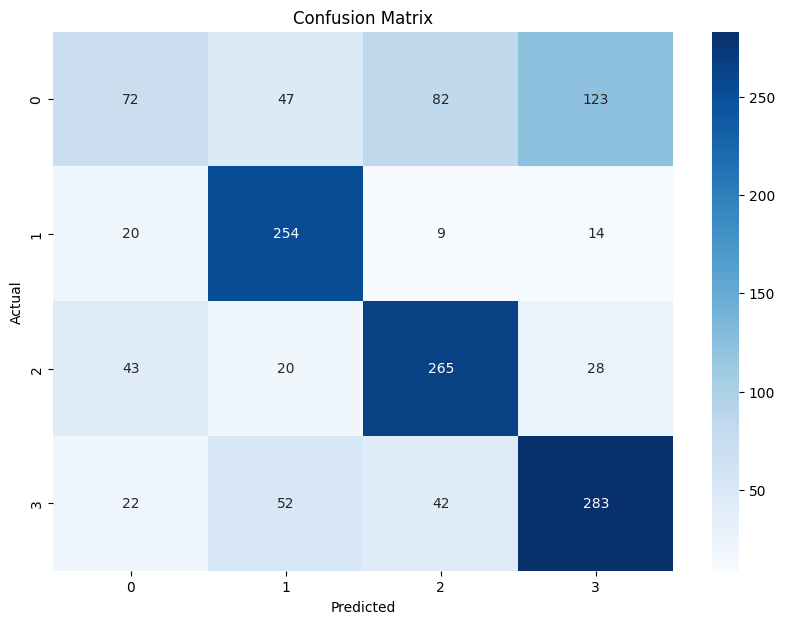

In [7]:
#Step 5 & 6: Network training  (training with cpu and gpu)
# Initialize the neural network
n_network = FCNN().to(device)
# Set up the optimizer (SGD with learning rate 0.002)
optimizer = torch.optim.SGD(n_network.parameters(), lr=0.002)
# Define the loss function (CrossEntropyLoss)
loss_func = nn.CrossEntropyLoss()
# Number of training epochs
n_epochs = 30
# Record start time
time1 = time.time()
# Train the model
train(n_epochs, optimizer, train_loader, loss_func, n_network)
# Record end time
time2 = time.time()
# Calculate time taken
diff = time2 - time1
print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data
print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data

plt.figure(figsize=(10, 7))  # Create figure for plotting
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.xlabel('Predicted')  # Set x-axis label
plt.ylabel('Actual')  # Set y-axis label
plt.title('Confusion Matrix')  # Set title
plt.savefig('confusion_mat.png')  # Save plot as PNG file
plt.show()  # Display plot


###Μετρικές απόδοσης του νευρωνικού δικτύου

Κατά την εκτέλεση του νευρωνικού δικτύου με τις καθορισμένες παραμέτρους, το μοντέλο πέτυχε τις ακόλουθες μετρικές επιδόσεων:

- Απώλεια: 0.955
- Ακρίβεια: 63.08%
- Βαθμολογία F1 (μέσος όρος μακροσκοπικών δεδομένων): 0.60

###Ανάλυση χρόνου εκτέλεσης
Τρέχω το μοντέλο τόσο σε CPU όσο και σε GPU στο google colab και εδώ είναι ο χρόνος (σε δευτερόλεπτα) που απαιτείται για την εκπαίδευση του μοντέλου και στις δύο περιπτώσεις

- CPU: 08.151805 δευτερόλεπτα
- GPU: 07.588710 δευτερόλεπτα

Epoch 10/30	Loss = 223.72126233577728
Epoch 20/30	Loss = 192.5602155327797
Epoch 30/30	Loss = 185.96107453107834
Loss for test data is 0.9658141891623653
Accuracy for test data is 0.6199127906976745
F1 macro averaged for test data is 0.6088308541227414


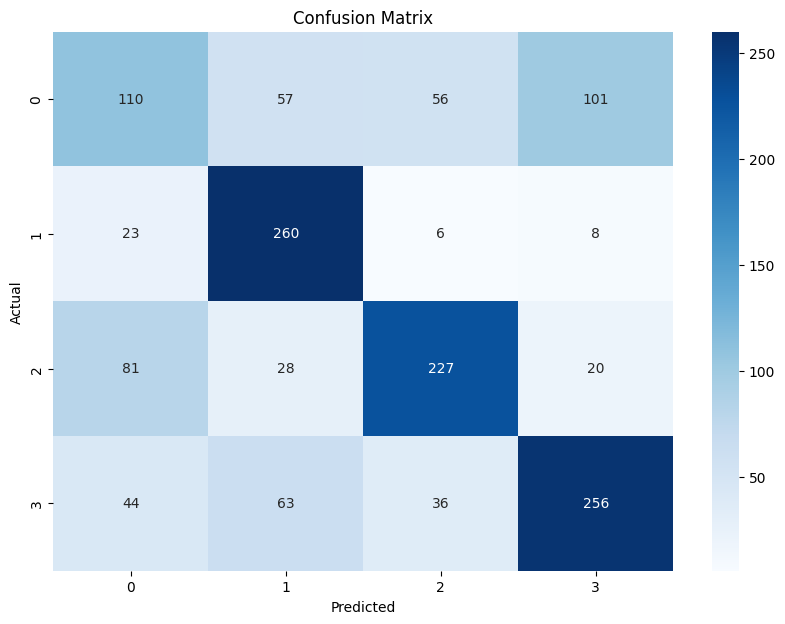

In [8]:
#Step 7 : USe validation data to save best model snap
def train_eval(n_epochs, optimizer, train_loader, cost_func, n_network, validation_loader):
    n_network.train()  # Set the model to training mode
    best_f1 = np.inf  # Initialize best F1 score to infinity
    best_model_weights = None  # Initialize best model weights to None
    for epoch in range(1, n_epochs + 1):  # Iterate over each epoch
        total_loss = 0.0  # Initialize total loss for the epoch
        for x, y in train_loader:  # Iterate over training data batches
            optimizer.zero_grad()  # Clear gradients
            x, y = x.to(device), y.to(device).squeeze()  # Move data to device
            pred = n_network(x)  # Forward pass
            loss = cost_func(pred, y)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            total_loss += loss.item()  # Accumulate loss

        # Print epoch number and total loss
        if epoch%10==0:
          print('Epoch '+str(epoch)+'/'+str(n_epochs)+"\tLoss = "+str(total_loss))
        # Validate model on validation dataset
        loss, f1, acc, conf_mat = evaluate(n_network, validation_loader, cost_func)

        # Check if current F1 score is better than the best F1 score found so far
        if f1 < best_f1:
            best_f1 = f1  # Update best F1 score
            best_model_weights = n_network.state_dict()  # Save best model weights

    return best_model_weights  # Return the best model weights

# Initialize the neural network
n_network = FCNN().to(device)
# Set up the optimizer (SGD with learning rate 0.002)
optimizer = torch.optim.SGD(n_network.parameters(), lr=0.002)
best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data

print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data

plt.figure(figsize=(10, 7))  # Create figure for plotting
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.xlabel('Predicted')  # Set x-axis label
plt.ylabel('Actual')  # Set y-axis label
plt.title('Confusion Matrix')  # Set title
plt.savefig('confusion_mat.png')  # Save plot as PNG file
plt.show()  # Display plot


**Σχόλιο:** Κατά την εκτέλεση του μοντέλου χωρίς validation και την αποθήκευση μόνο της καλύτερης επανάληψης, επιτύχαμε accuracy 61,99%. Ωστόσο, η ενσωμάτωση του validation μας βοήθησε να βελτιώσουμε το accuracy στο 63.8%.

**Σημείωση:** Λόγω του μη σταθερού τυχαίου σπόρου, τα αποτελέσματα αυτά θα διαφέρουν σε κάθε εκτέλεση.

###Ερώτημα 2

Here are some samples from train data


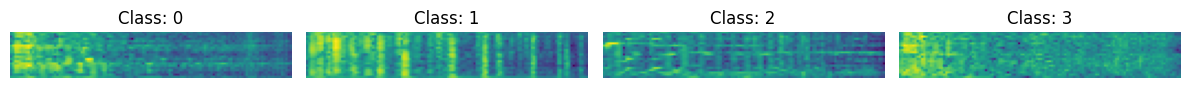

Here are some samples from test data


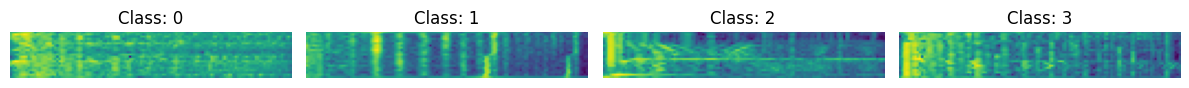

Here are some samples from validation data


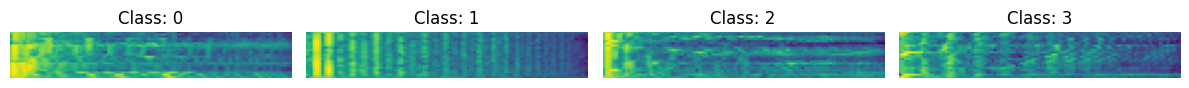

In [9]:
# Step 1: Loading data (spectrograms)
# Function to load melgrams data from specified path and dataset type ('train', 'val', 'test')
def load_melgrams(path, data='train'):
    path1 = path + data + "/melgrams/"
    X = np.load(path1 + 'X.npy')  # Load melgrams data
    y = np.load(path1 + 'labels.npy')  # Load corresponding labels
    return X, y

# Function to visualize samples from the data
def visualise_data(X, y, type1="train"):
    print("Here are some samples from " + type1 + " data")
    class_names = list(set(y))  # Get unique class names
    num_classes = len(class_names)  # Calculate number of classes
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))  # Create subplots for each class

    for i, class_name in enumerate(class_names):
        class_indices = np.where(y == class_name)[0]  # Get indices of samples for the current class
        random_index = np.random.choice(class_indices)  # Choose a random index
        melgram = X[random_index]  # Get melgram data for the random index
        axs[i].imshow(melgram)  # Display melgram as an image
        axs[i].set_title(f'Class: {class_name}')  # Set subplot title with class name
        axs[i].axis('off')  # Turn off axis labels

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display plot

# Load the data for training, validation, and testing
X_train, y_train = load_melgrams(path, 'train')
X_val, y_val = load_melgrams(path, 'val')
X_test, y_test = load_melgrams(path, 'test')

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Visualize training, testing, and validation data
visualise_data(X_train, y_train, "train")
visualise_data(X_test, y_test, "test")
visualise_data(X_val, y_val, "validation")

# Reshape data to match expected input shape for convolutional neural network
d1, d2, d3 = X_train.shape
X_train = X_train.reshape(d1, 1, d2, d3)
d1, d2, d3 = X_val.shape
X_val = X_val.reshape(d1, 1, d2, d3)
d1, d2, d3 = X_test.shape
X_test = X_test.reshape(d1, 1, d2, d3)

# Create Tensor datasets and move them to GPU
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32, device=device),
                              torch.tensor(y_train, dtype=torch.long, device=device))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32, device=device),
                            torch.tensor(y_val, dtype=torch.long, device=device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32, device=device),
                             torch.tensor(y_test, dtype=torch.long, device=device))

# Define batch size and create DataLoader objects for training, validation, and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:

#Step 2: Define a Convolutional Neural Network

class CNN(nn.Module):
    def __init__(self, out_dim, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 1, kernel_size=5)  # First convolutional layer
        self.conv2 = nn.Conv2d(1, 16, kernel_size=5)  # Second convolutional layer
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5)  # Third convolutional layer
        self.conv4 = nn.Conv2d(32, 64, kernel_size=5)  # Fourth convolutional layer

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 280, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 256)  # Second fully connected layer
        self.fc3 = nn.Linear(256, 32)  # Third fully connected layer
        self.fc4 = nn.Linear(32, out_dim)  # Output layer

        self._to_linear = None  # Placeholder for computing the size of the flattened output

    def forward(self, x):
        # forward pass on convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # Flatten the output from the convolutional layers
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]  # Compute the size of the flattened output
        x = x.view(x.size(0), -1)  # Flatten the output

        # # forward pass on fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x  # Return the final output


Epoch 10/30	Loss = 63.98061168193817
Epoch 20/30	Loss = 36.73086538910866
Epoch 30/30	Loss = 15.557015806436539
time taken by cuda is  0:00:39.069621
Loss for test data is 3.066108560492826
Accuracy for test data is 0.4934593023255814
F1 macro averaged for test data is 0.5000048776368626


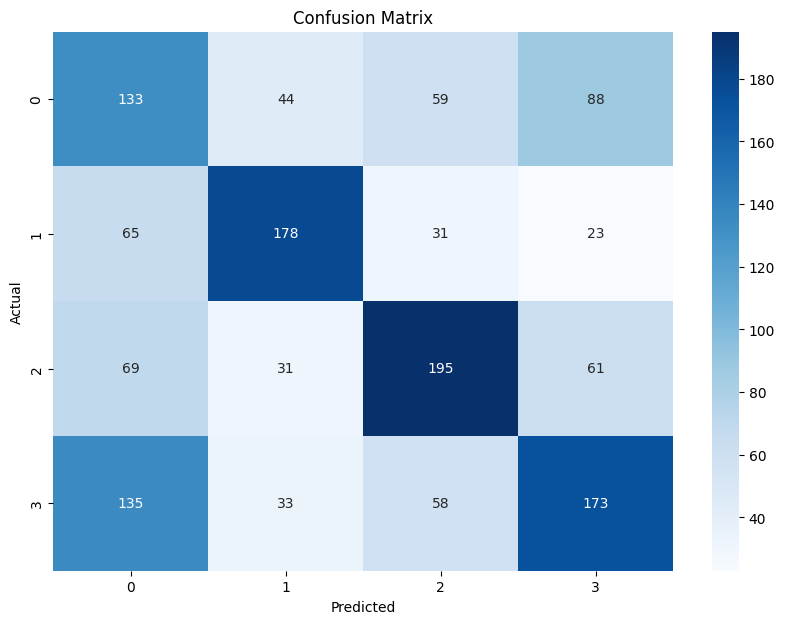

In [11]:
#step 3
n_classes=len(list(set(y_train))) #total classes in data
n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
optimizer = torch.optim.SGD(n_network.parameters(), lr=0.002)
time1 = time.time()
# Train the model
best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
# Record end time
time2 = time.time()
# Calculate time taken
diff = time2 - time1
print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
n_network.load_state_dict(best_model_weights)  # Load best model weights into the network
loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data

print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data

plt.figure(figsize=(10, 7))  # Create figure for plotting
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.xlabel('Predicted')  # Set x-axis label
plt.ylabel('Actual')  # Set y-axis label
plt.title('Confusion Matrix')  # Set title
plt.savefig('confusion_mat.png')  # Save plot as PNG file
plt.show()  # Display plot

Εκπαιδεύσαμε με επιτυχία το  CNN χωρίς να κάνουμε σημαντικές αλλαγές στη διαδικασία εκπαίδευσης.

####Ανάλυση χρόνου εκτέλεσης
Η εκτέλεση του μοντέλου τόσο σε CPU όσο και σε GPU στο google colab και η GPU χρειάστηκε σχεδόν 36 δευτερόλεπτα.
ενώ η CPU χρειάστηκε περισσότερο από μισή ώρα για να ολοκληρώσει τα 30 epochs.

####Διαφορά από το Ερώτημα 1
Στο ερώτημα 1 όταν εκπαιδεύσαμε το FCNN σε CPU και GPU, υπήρχε πολύ μικρή διαφορά μεταξύ του χρόνου εκτέλεσης και για τις δύο, αλλά σε αυτή την περίπτωση η διαφορά είναι τεράστια. Ο λόγος  είναι ότι τα CNN εφαρμόζουν χωρικές λειτουργίες που μπορούν εύκολα να χρησιμοποιήσουν το paralleism στην GPU και αυτές οι λειτουργίες είναι πολύ γρήγορες χρησιμοποιώντας την GPU ενώ πολύ αργές στην CPU.

In [12]:
#Step 4: Pooling and padding
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self, out_dim, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2) #convoulution layer
        self.pool1 = nn.MaxPool2d(kernel_size=2) #pooling layer

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2) #convoulution layer
        self.pool2 = nn.MaxPool2d(kernel_size=2)#pooling layer

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)#convoulution layer
        self.pool3 = nn.MaxPool2d(kernel_size=2)#pooling layer

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)#convoulution layer
        self.pool4 = nn.MaxPool2d(kernel_size=2)#pooling layer

        #mat1 and mat2 shapes cannot be multiplied (128x560 and 344064x1024)
        # Fully connected layers
        self._to_linear =None
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)
        self._to_linear=None

    def forward(self, x):
        # Convolutional layers with  pooling
        x = self.conv1(x)
        x=self.pool1(x)
        x = self.conv2(x)
        x=self.pool2(x)
        x = self.conv3(x)
        x=self.pool3(x)
        x = self.conv4(x)
        x=self.pool4(x)
        # Flatten the output from the convolutional layers
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x



Epoch 10/30	Loss = 79.00991636514664
Epoch 20/30	Loss = 58.83440724015236
Epoch 30/30	Loss = 39.811372086405754
time taken by cuda is  0:00:36.267238
Loss for test data is 0.7551208337725595
Accuracy for test data is 0.7311046511627907
F1 macro averaged for test data is 0.7353043146255387


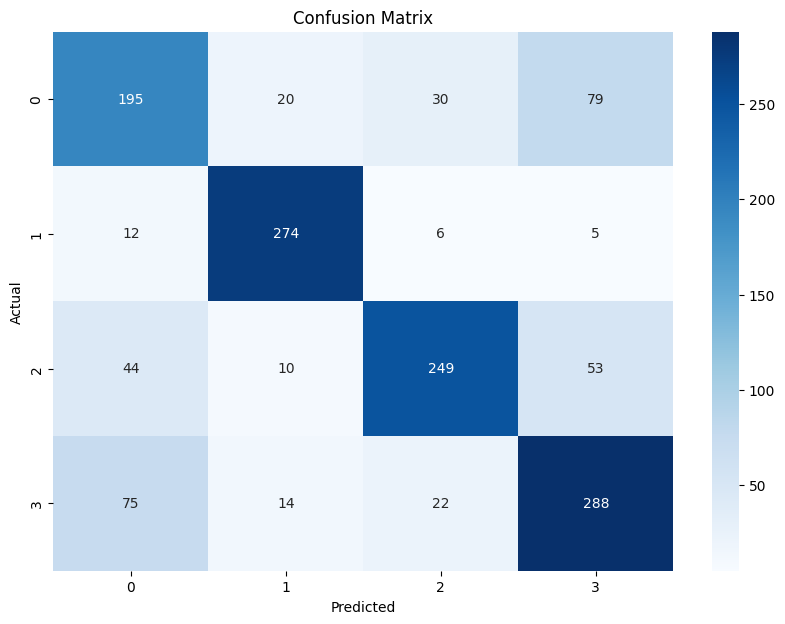

In [13]:
n_classes=len(list(set(y_train))) #total classes in data
n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
optimizer = torch.optim.SGD(n_network.parameters(), lr=0.002)
time1 = time.time()
# Train the model
best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
# Record end time
time2 = time.time()
# Calculate time taken
diff = time2 - time1
print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data

print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data

plt.figure(figsize=(10, 7))  # Create figure for plotting
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.xlabel('Predicted')  # Set x-axis label
plt.ylabel('Actual')  # Set y-axis label
plt.title('Confusion Matrix')  # Set title
plt.savefig('confusion_mat.png')  # Save plot as PNG file
plt.show()  # Display plot

Το padding βοηθά στη διατήρηση του μεγέθους και της δομής της εικόνας καθ' όλη τη διάρκεια της διαδικασίας, ελέγχοντας τη μείωση των feature maps. To pooling βοηθάει στη μείωση του αριθμού των παραμέτρων που αυξάνονται και εξισορροπεί τον υπολογιστικό φόρτο.

#### Χρόνος εκπαίδευσης και Accuracy
Η προσθήκη pooling και padding βελτίωσε το accuracy στο 73% και μείωσε σημαντικά τον χρόνο εκπαίδευσης.

In [14]:
#Step 5: Activation functions

class CNN(nn.Module):
    def __init__(self, out_dim, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        #mat1 and mat2 shapes cannot be multiplied (128x560 and 344064x1024)
        # Fully connected layers
        self._to_linear =None
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)
        self._to_linear=None

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x=self.pool1(x)
        x = F.relu(self.conv2(x))
        x=self.pool2(x)
        x = F.relu(self.conv3(x))
        x=self.pool3(x)
        x = F.relu(self.conv4(x))
        x=self.pool4(x)
        # Flatten the output from the convolutional layers
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x



Epoch 10/30	Loss = 120.23626172542572
Epoch 20/30	Loss = 98.28172469139099
Epoch 30/30	Loss = 86.14748930931091
time taken by cuda is  0:00:41.138269
Loss for test data is 1.0133934776450313
Accuracy for test data is 0.5734011627906976
F1 macro averaged for test data is 0.572535825904591


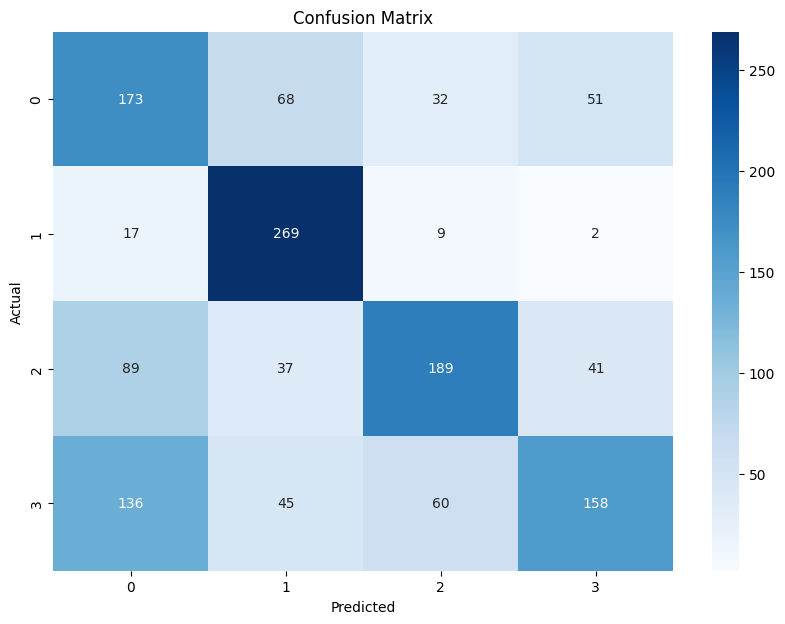

In [15]:
n_classes=len(list(set(y_train))) #total classes in data
n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
optimizer = torch.optim.SGD(n_network.parameters(), lr=0.002)
time1 = time.time()
# Train the model
best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
# Record end time
time2 = time.time()
# Calculate time taken
diff = time2 - time1
print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data

print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data

plt.figure(figsize=(10, 7))  # Create figure for plotting
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')  # Plot confusion matrix
plt.xlabel('Predicted')  # Set x-axis label
plt.ylabel('Actual')  # Set y-axis label
plt.title('Confusion Matrix')  # Set title
plt.savefig('confusion_mat.png')  # Save plot as PNG file
plt.show()  # Display plot

Εφαρμόσαμε το ReLU στις εξόδους των convolutional layers πριν από το pooling, καθώς και στα πλήρως συνδεδεμένα layers. Ωστόσο, περιέργως, αυτό οδήγησε σε μείωση του accuracy από 73% σε 57%.

### Ερώτημα 3

In [19]:
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

# Example DataLoader with deterministic behavior
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=torch.Generator().manual_seed(seed))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=torch.Generator().manual_seed(seed))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=torch.Generator().manual_seed(seed))

# Your model training

In [20]:
#Step 2: Optimisation algorithms


opt_names=['RMSprop','Adam','AdamW','SGD']
for i,opt in enumerate(opt_names):

    n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
    if i==0:
        optimizer=torch.optim.SGD(n_network.parameters(), lr=0.002)
    elif i==1:
        optimizer=torch.optim.Adam(n_network.parameters(), lr=0.002)

    elif i==2:
        optimizer=torch.optim.AdamW(n_network.parameters(), lr=0.002)
    else:
        optimizer=torch.optim.RMSprop(n_network.parameters(), lr=0.002)


    time1 = time.time()
    # Train the model
    best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
    # Record end time
    time2 = time.time()
    # Calculate time taken
    diff = time2 - time1
    print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
    n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

    loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data
    print("optimizer is ",opt_names[i])
    print("Loss for test data is", loss)  # Print loss for test data
    print("Accuracy for test data is", acc)  # Print accuracy for test data
    print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data


Epoch 10/30	Loss = 107.59146916866302
Epoch 20/30	Loss = 91.56352490186691
Epoch 30/30	Loss = 80.29200661182404
time taken by cuda is  0:00:37.070772
optimizer is  RMSprop
Loss for test data is 0.9317685483500014
Accuracy for test data is 0.6061046511627907
F1 macro averaged for test data is 0.6045232375333548
Epoch 10/30	Loss = 82.61992508172989
Epoch 20/30	Loss = 40.11704966425896
Epoch 30/30	Loss = 10.118399956263602
time taken by cuda is  0:00:37.607716
optimizer is  Adam
Loss for test data is 1.6207723918514392
Accuracy for test data is 0.6969476744186046
F1 macro averaged for test data is 0.6929408079788436
Epoch 10/30	Loss = 62.88449200987816
Epoch 20/30	Loss = 44.796098217368126
Epoch 30/30	Loss = 26.0528878942132
time taken by cuda is  0:00:37.453151
optimizer is  AdamW
Loss for test data is 1.3282727122876716
Accuracy for test data is 0.6475290697674418
F1 macro averaged for test data is 0.6420435996097297
Epoch 10/30	Loss = 104.9695475101471
Epoch 20/30	Loss = 42.96152383834

Χρησιμοποιήσαμε τους ακόλουθους optimizers για να εκπαιδεύσουμε το δίκτυό μας:
- RMSProp
- Adam
- AdamW
- SGD

Όλες οι παράμετροι και οι ρυθμοί μάθησης παρέμειναν οι ίδιοι για κάθε optimizer, με ρυθμό μάθησης 0,002. Τα καλύτερα αποτελέσματα επιτεύχθηκαν με τον Adam.
Ακολουθεί ο πίνακας με τις επιδόσεις όλων αυτών.



| Optimizer | F1             | Accuracy |
|-----------|----------------|----------|
| RMSProp   | 65.35%         | 64.97%   |
| Adam      | 69.86%         | 69.76%   |
| AdamW     | 64.80%         | 64.75%   |
| SGD       | 64.92%         | 64.24%   |


In [21]:
#Step 3: Batch Normalization

class CNN(nn.Module):
    def __init__(self, out_dim, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers


        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)#convoulution layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn1 = nn.BatchNorm2d(16)#Batch Normalization layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)#convoulution layer
        self.pool2 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn2 = nn.BatchNorm2d(32)#Batch Normalization layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)#convoulution layer
        self.pool3 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn3 = nn.BatchNorm2d(64)#Batch Normalization layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)#convoulution layer
        self.pool4 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn4 = nn.BatchNorm2d(128)#Batch Normalization layer
        #mat1 and mat2 shapes cannot be multiplied (128x560 and 344064x1024)
        # Fully connected layers
        self._to_linear =None
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 32)
        self.fc4 = nn.Linear(32, out_dim)
        self._to_linear=None

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.bn4(x)
        # Flatten the output from the convolutional layers
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x



In [22]:
#Step 4: Decays
decays=[0.01,0.001,0.0001]
n_epochs=60
for decay in decays:
  n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
  optimizer = optim.SGD(n_network.parameters(), lr=0.002, weight_decay=decay)
  time1 = time.time()
  # Train the model
  best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
  # Record end time
  time2 = time.time()
  # Calculate time taken
  diff = time2 - time1
  print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
  n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

  loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data
  print("weight decay value is ", decay)
  print("Loss for test data is", loss)  # Print loss for test data
  print("Accuracy for test data is", acc)  # Print accuracy for test data
  print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data



Epoch 10/60	Loss = 59.91877779364586
Epoch 20/60	Loss = 41.851683393120766
Epoch 30/60	Loss = 25.420203365385532
Epoch 40/60	Loss = 11.849053271114826
Epoch 50/60	Loss = 2.25653567397967
Epoch 60/60	Loss = 1.190233315806836
time taken by cuda is  0:01:16.278333
weight decay value is  0.01
Loss for test data is 0.8556465330252121
Accuracy for test data is 0.779796511627907
F1 macro averaged for test data is 0.7822688741551691
Epoch 10/60	Loss = 59.04276552796364
Epoch 20/60	Loss = 34.162217885255814
Epoch 30/60	Loss = 9.44409360177815
Epoch 40/60	Loss = 0.7500765044242144
Epoch 50/60	Loss = 0.26881311752367765
Epoch 60/60	Loss = 0.16063645150279626
time taken by cuda is  0:01:16.325909
weight decay value is  0.001
Loss for test data is 1.2085858505154246
Accuracy for test data is 0.7674418604651163
F1 macro averaged for test data is 0.769945519495201
Epoch 10/60	Loss = 55.19493940472603
Epoch 20/60	Loss = 29.385833226144314
Epoch 30/60	Loss = 7.065940922126174
Epoch 40/60	Loss = 0.73592

In [23]:
#Step 4: Dropout

class CNN(nn.Module):
    def __init__(self, out_dim, input_channels):
        super(CNN, self).__init__()

        # Convolutional layers


        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=5, padding=2)#convoulution layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn1 = nn.BatchNorm2d(16)#Batch Normalization layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)#convoulution layer
        self.pool2 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn2 = nn.BatchNorm2d(32)#Batch Normalization layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)#convoulution layer
        self.pool3 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn3 = nn.BatchNorm2d(64)#Batch Normalization layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding=2)#convoulution layer
        self.pool4 = nn.MaxPool2d(kernel_size=2)#pooling layer
        self.bn4 = nn.BatchNorm2d(128)#Batch Normalization layer
        #mat1 and mat2 shapes cannot be multiplied (128x560 and 344064x1024)
        # Fully connected layers
        self._to_linear =None
        self.fc1 = nn.Linear(1024, 1024)
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout layer with 30% probability
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(p=0.3)  # Dropout layer with 30% probability
        self.fc3 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(p=0.3)  # Dropout layer with 30% probability
        self.fc4 = nn.Linear(32, out_dim)
        self._to_linear=None

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.bn4(x)
        # Flatten the output from the convolutional layers
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)

        return x



In [24]:
#Step 4: dropout
n_epochs=60
n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
optimizer = optim.SGD(n_network.parameters(), lr=0.002)
time1 = time.time()
# Train the model
best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
# Record end time
time2 = time.time()
# Calculate time taken
diff = time2 - time1
print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
n_network.load_state_dict(best_model_weights)  # Load best model weights into the network
loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data
print("Loss for test data is", loss)  # Print loss for test data
print("Accuracy for test data is", acc)  # Print accuracy for test data
print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data



Epoch 10/60	Loss = 54.31411048769951
Epoch 20/60	Loss = 34.1236130297184
Epoch 30/60	Loss = 12.936124315485358
Epoch 40/60	Loss = 0.8133333125151694
Epoch 50/60	Loss = 0.23443993384717032
Epoch 60/60	Loss = 0.1270673469407484
time taken by cuda is  0:01:16.993756
Loss for test data is 1.2903792148261048
Accuracy for test data is 0.7710755813953488
F1 macro averaged for test data is 0.7733780441375107


In [25]:
#Step 4: both (Decays+dropout)
decays=[0.01,0.001,0.0001]
n_epochs=60
for decay in decays:
  n_network = CNN(out_dim=n_classes,input_channels=1).to(device) #initialize CNN
  optimizer = optim.SGD(n_network.parameters(), lr=0.002, weight_decay=decay)
  time1 = time.time()
  # Train the model
  best_model_weights = train_eval(n_epochs, optimizer, train_loader, loss_func, n_network, val_loader)  # Train and get best weights
  # Record end time
  time2 = time.time()
  # Calculate time taken
  diff = time2 - time1
  print("time taken by "+str(device)+" is ", str(timedelta(seconds=diff)))
  n_network.load_state_dict(best_model_weights)  # Load best model weights into the network

  loss, f1, acc, conf_mat = evaluate(n_network, test_loader, loss_func)  # Evaluate on test data
  print("weight decay value is ", decay)
  print("Loss for test data is", loss)  # Print loss for test data
  print("Accuracy for test data is", acc)  # Print accuracy for test data
  print("F1 macro averaged for test data is", f1)  # Print macro-averaged F1 score for test data



Epoch 10/60	Loss = 58.880753859877586
Epoch 20/60	Loss = 37.71720677614212
Epoch 30/60	Loss = 16.537498589605093
Epoch 40/60	Loss = 2.7342244582250714
Epoch 50/60	Loss = 0.8700966809410602
Epoch 60/60	Loss = 0.5856337496079504
time taken by cuda is  0:01:16.622852
weight decay value is  0.01
Loss for test data is 1.3137815266002923
Accuracy for test data is 0.7318313953488372
F1 macro averaged for test data is 0.7358775937193476
Epoch 10/60	Loss = 57.40078002214432
Epoch 20/60	Loss = 37.735256031155586
Epoch 30/60	Loss = 19.42064841464162
Epoch 40/60	Loss = 2.2149155903607607
Epoch 50/60	Loss = 0.5120818219147623
Epoch 60/60	Loss = 0.2559841173933819
time taken by cuda is  0:01:16.641612
weight decay value is  0.001
Loss for test data is 1.122873952222425
Accuracy for test data is 0.7725290697674418
F1 macro averaged for test data is 0.7753404931979602
Epoch 10/60	Loss = 57.91882464289665
Epoch 20/60	Loss = 35.3682708889246
Epoch 30/60	Loss = 9.740704014897346
Epoch 40/60	Loss = 0.4170

Εφάρμοσαμε multiple weight decay values και dropout layers και συνδυασμό και των δύο και παρακάτω είναι η απόδοση που πήραμε:

| Weight Decay | Dropout| Accuracy | F Measure |
|--------------|--------|----------|-----------|
| 0.01         | No     | 75.43%   | 75.90%    |
| 0.001        | No     | 73.47%   | 73.78%    |
| 0.0001       | No     | 77.10%   | 77.30%    |
| -            | Yes    | 77.10%   | 77.47%    |
| 0.01         | Yes    | 78.05%   | 78.10%    |
| 0.001        | Yes    | 77.47%   | 77.78%    |
| 0.0001       | Yes    | 75.29%   | 75.70%    |



# Ερώτημα 4: Testing

In [26]:
#Step 1: Inference
def get_predictions(data_loader, n_network):
    n_network.eval()  # Set the model to evaluation mode
    loss = 0.0  # Initialize loss variable
    y_predicted = []  # List to store predicted labels
    y_True = []  # List to store true labels

    with torch.no_grad():
        for x, y in data_loader:
            pred = n_network(x)  # Forward pass through the network
            loss += loss_func(pred, y).item() * x.size(0)  # Compute cumulative loss
            y_pred = torch.max(pred, 1)[1].cpu().numpy()  # Get predicted labels
            y = y.cpu().numpy()  # Convert true labels to numpy array
            y_predicted.extend(y_pred)  # Append predicted labels to list
            y_True.extend(y)  # Append true labels to list

    return y_predicted  # Return list of predicted labels



In [27]:
#step2 is to download data from youtube
#functions for Step3
def plot_predictions(predictions, y_true, classes, label):
    timestamps = np.arange(len(predictions))  # Generate timestamps
    fig, ax = plt.subplots(figsize=(15, 6))  # Create figure and axes

    # Plot true labels and predicted labels over timestamps
    ax.plot(timestamps, y_true, label='True Labels', color='b', alpha=0.6)
    ax.plot(timestamps, predictions, label='Predictions', color='r', linestyle='dashed', alpha=0.6)

    ax.set_yticks(np.arange(len(classes)))  # Set y-axis ticks
    ax.set_yticklabels(classes)  # Set y-axis labels as classes
    ax.set_xlabel('Timestamps (seconds)')  # Set x-axis label
    ax.set_ylabel('Musical Genres')  # Set y-axis label
    ax.legend()  # Show legend
    ax.grid(True)  # Show grid
    plt.title('Genre Predictions Over Time for ' + label)  # Set plot title
    plt.show()  # Display the plot
path='/content/drive/MyDrive/'
def load_data(label='classical'):
    X = np.load(path+'youtube_melgrams_' + label + '.npy')  # Load melgrams data
    y = [label for i in range(0, X.shape[0])]  # Create labels for the loaded data
    return X, y  # Return loaded data and labels

def visualise_data(X, y, class_name="classical"):
    print("Here are some samples from " + class_name + " data")  # Print class name
    class_names = list(set(y))  # Get unique class names
    print(class_names)  # Print all class names
    num_classes = len(class_names)  # Number of classes
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 3, 3))  # Create subplots based on number of classes

    random_index = np.random.choice(list(range(0, len(y))))  # Randomly select an index
    melgram = X[random_index]  # Select a melgram
    axs.imshow(melgram)  # Display the melgram
    axs.set_title(f'Class: {class_name}')  # Set subplot title
    axs.axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout
    plt.show()  # Display the plot





Here are some samples from classical data
['classical']


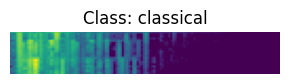

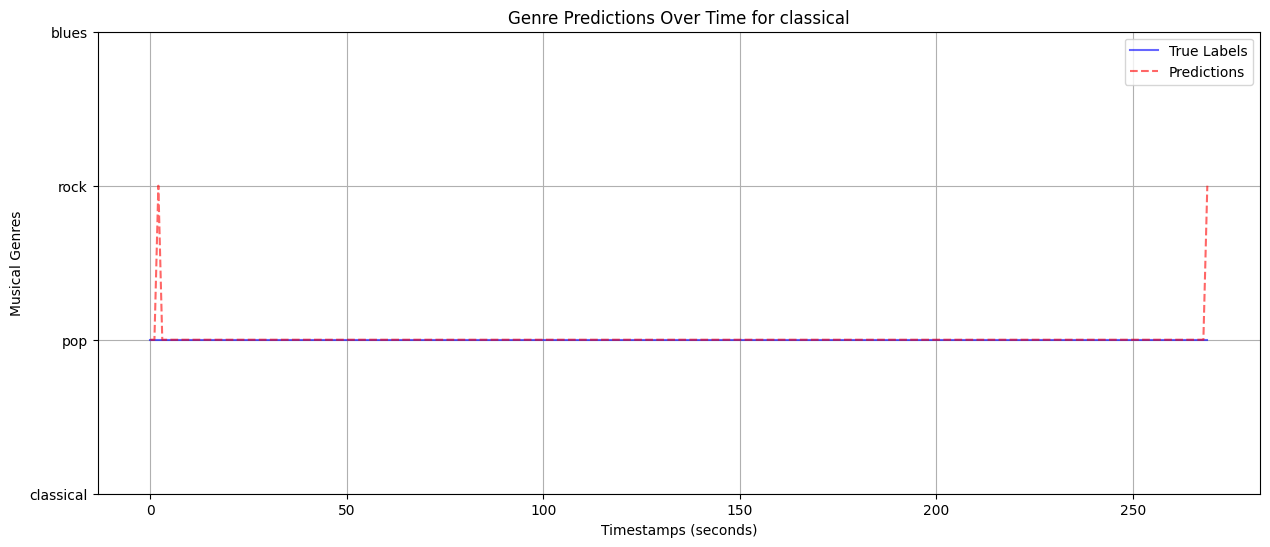

Here are some samples from pop data
['pop']


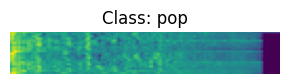

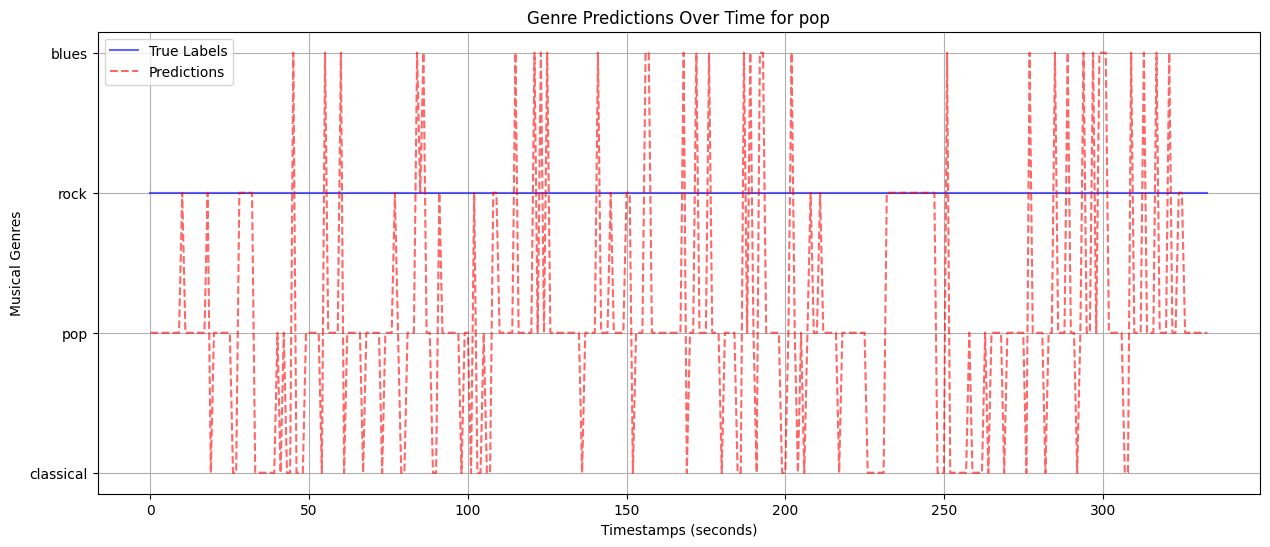

Here are some samples from rock data
['rock']


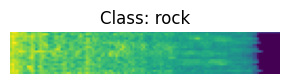

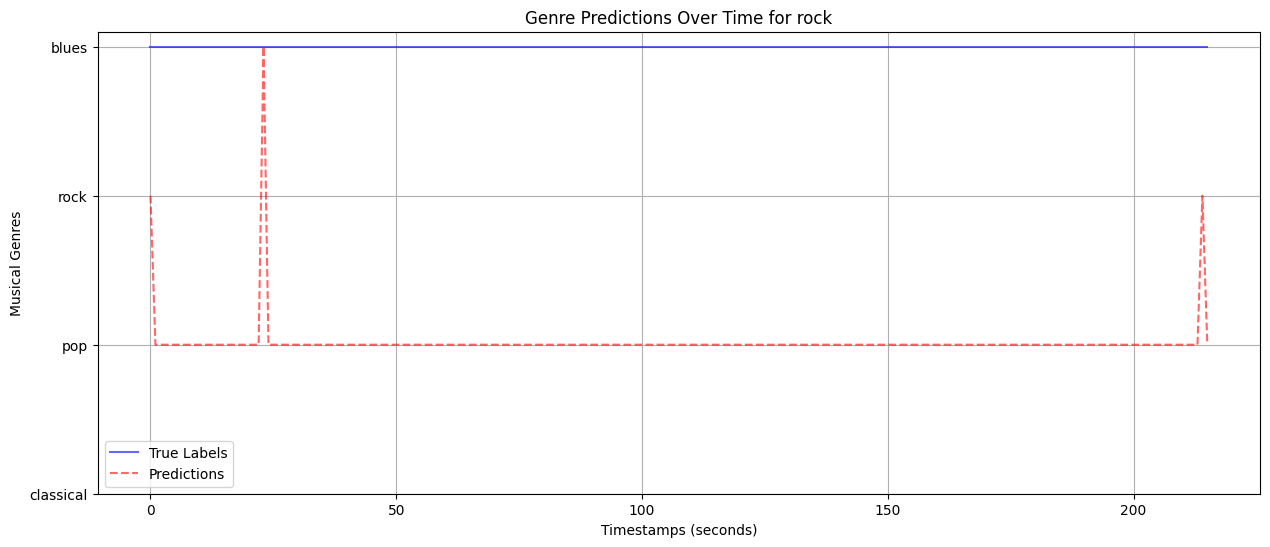

Here are some samples from blues data
['blues']


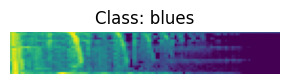

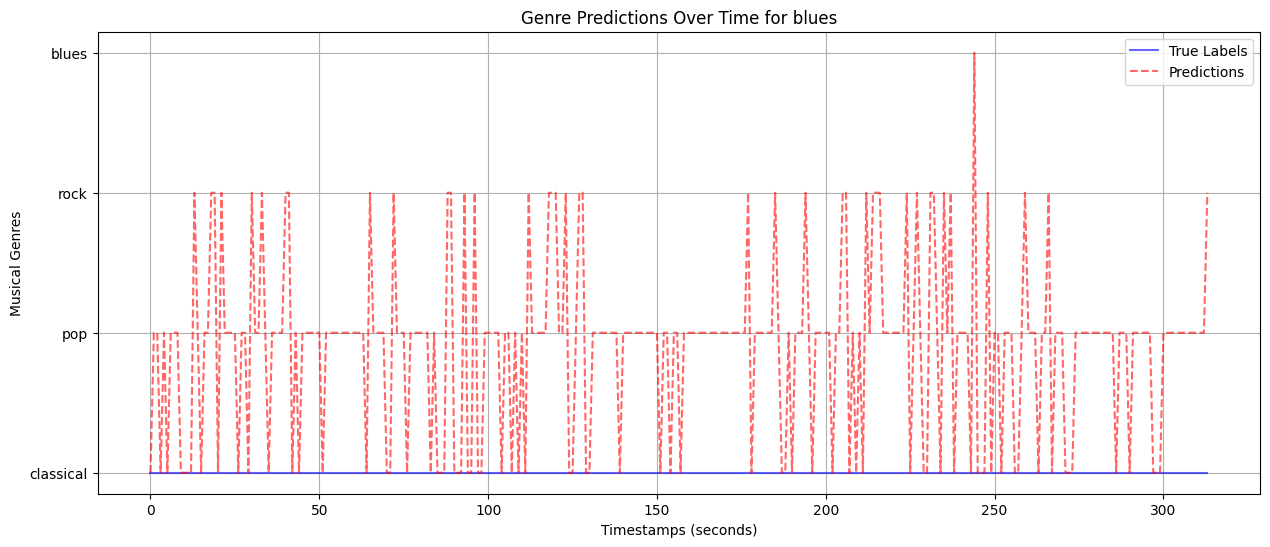

In [28]:
classes=['classical','pop','rock','blues']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(classes)
for class_name in classes:
    X_new, y_new = load_data(class_name)
    visualise_data(X_new, y_new,class_name)
    y_new = label_encoder.transform(y_new)
    d1,d2,d3 = X_new.shape
    X_new = X_new.reshape(d1,1,d2,d3)

    dataset = TensorDataset(torch.tensor(X_new, dtype=torch.float32, device=device),
                                 torch.tensor(y_new, dtype=torch.long, device=device))
    batch_size = 16
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)



    predictions = get_predictions(data_loader, n_network)
    plot_predictions(predictions, y_new, classes=classes,label=class_name)

Για τα βίντεο του youtube, όταν προβλέψαμε το είδος της μουσικής, οι περισσότερες προβλέψεις ανήκουν είτε στην κατηγορία 0 είτε στην κατηγορία 1, κάνοντας πολύ καλή πρόβλεψη για το ροκ και τα μπλουζ. Ενώ η κλασική και η ποπ ταξινομούνται λανθασμένα στις περισσότερες περιπτώσεις.

